In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statistics
import CococoNet_reader
import Name_resolver
import Go_annotations

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [4]:
def get_fc_sc_btw_two_species_with_gene_list(species_1,species_2,list_of_genes_in_species_1_as_panda):
    import pandas as pd
    import numpy as np
    import Name_resolver as nr

    #Deal with Name
    common_1 = Name_resolver.species_name_resolver(species_1= species_1,desired_type='common')
    common_2 = Name_resolver.species_name_resolver(species_1= species_2,desired_type='common')
    scientific_1 = Name_resolver.species_name_resolver(species_1= species_1, desired_type='scientific')
    scientific_2 = Name_resolver.species_name_resolver(species_1= species_2, desired_type='scientific')

    if scientific_1 == scientific_2:
        raise NameError("Species are the Same, submit different species")

    # Get Path for Orthologs
    path_to_fc_scores_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_human_to_mammal_scores.csv',index_col = 0)
    path_to_fc_scores = path_to_fc_scores_mapper.at[scientific_1,scientific_2]

    fc_scores_for_pair = pd.read_csv(path_to_fc_scores)
    file_name = path_to_fc_scores.split('/')[-1]
    file_name = file_name.split('_')
    if file_name[0] == common_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp1_gene'})

        #Only include this on Human Pairwise data
        split_up_names = fc_scores_for_pair['sp1_gene'].str.split(".")
        if len(split_up_names[0]) > 1:
            fixed_format = [item[0] for item in fc_scores_for_pair['sp2_gene'].str.split(".")]
            fc_scores_for_pair['sp1_gene'] = fixed_format
        


        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(fc_scores_for_pair,on = 'sp1_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)

    if file_name[1] == common_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp2_gene'})

        #Only include this on Human Pairwise data
        split_up_names = fc_scores_for_pair['sp2_gene'].str.split(".")
        if len(split_up_names[0]) > 1:
            fixed_format = [item[0] for item in fc_scores_for_pair['sp2_gene'].str.split(".")]
            fc_scores_for_pair['sp2_gene'] = fixed_format
        

        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(fc_scores_for_pair,on = 'sp2_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    # return fc_sc_map,species_name
    return fc_sc_map

In [5]:
all_go_terms = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
all_go_terms[['human']] = np.nan
all_go_terms

,Name,human
GO:0000001,mitochondrion inheritance,NaN
GO:0000002,mitochondrial genome maintenance,NaN
GO:0000003,reproduction,NaN
GO:0000006,high-affinity zinc transmembrane transporter a...,NaN
GO:0000007,low-affinity zinc ion transmembrane transporte...,NaN
...,...,...
GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,NaN
GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,NaN
GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,NaN
GO:2001316,kojic acid metabolic process,NaN


In [6]:
cococonet_mammals = ['human','dog','horse','goat','rabbit','rat','mouse','chimp','crabm','rhesusm','boar','cow','sheep']
mammal_combinations = itertools.permutations(cococonet_mammals,2)
mammal_combinations = list(map(list,mammal_combinations))


In [7]:
# species = 'human'
# print(species)
# combos_that_start_with_species = []
# for combo in mammal_combinations:
#     if combo[0] == species:
#         combos_that_start_with_species.append(combo)
# current_species_annotations = Go_annotations.get_go_annotations_as_panda(species)
# go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
# go_groups_with_counts = go_groups_with_counts[go_groups_with_counts < 2000]
# go_groups_with_counts = go_groups_with_counts[go_groups_with_counts > 10]
# for current_go_term in go_groups_with_counts.index.to_list():
#     current_go_term_list_of_fc_scores = []
#     genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#     genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#     for current_combination in combos_that_start_with_species:
#         current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#         mean_fc = current_fc_map.mean()[0]
#         current_go_term_list_of_fc_scores.append(mean_fc)
#     mean_across_species = statistics.mean(current_go_term_list_of_fc_scores)
#     all_go_terms.at[current_go_term,species] = mean_across_species


In [8]:
#all_go_terms.to_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/temp_fc_scores_for_human_pairwise.csv')

In [9]:
all_go_terms = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/temp_fc_scores_for_human_pairwise.csv',index_col= 0)

In [10]:
average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)

/tmp/ipykernel_2821848/1298046529.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)


In [11]:
# cococonet_map = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/All_CoCoCoNet_Paths.csv')
# all_go_group_egad_results = pd.DataFrame(index = all_go_terms.index)

# species = 'human'
# combos_that_start_with_species = []
# current_species_path_cococonet = cococonet_map['Path'].loc[cococonet_map['Common Name'] == species].item()
# for combo in mammal_combinations:
#     if combo[0] == species:
#         combos_that_start_with_species.append(combo)
# current_species_annotations = Go_annotations.get_go_annotations_as_panda(species)
# go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
# go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
# go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
# go_groups_for_egad = go_groups_with_counts.index.to_list()
# annotations_to_run_egad_on = current_species_annotations[go_groups_for_egad]
# current_scientific_name = Name_resolver.species_name_resolver(species_1 = species,desired_type = 'scientific') 
# current_cococonet = CococoNet_reader.read_cococonet(species)
# egad_results = run_egad(go = annotations_to_run_egad_on, nw = current_cococonet,min_count =10, max_count = 2000 )
# all_go_group_egad_results = all_go_group_egad_results.merge(right = egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
# all_go_group_egad_results = all_go_group_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})

In [12]:
#all_go_group_egad_results.to_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/temp_go_group_results.csv')

In [13]:
all_go_group_egad_results = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Temp_tables/temp_go_group_results.csv', index_col= 0)

In [14]:
all_egad_results = all_go_group_egad_results[['human AUC']]

In [15]:
egad_means = all_egad_results.mean(axis = 1)
egad_means

GO:0000001         NaN
GO:0000002    0.556401
GO:0000003    0.583122
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051196    0.638112
GO:0051185         NaN
GO:0045075         NaN
GO:0045074         NaN
GO:0050701    0.882616
Length: 44332, dtype: float64

In [16]:
egad_means.dropna()

GO:0000002    0.556401
GO:0000003    0.583122
GO:0000018    0.654468
GO:0000027    0.820107
GO:0000028    0.809442
                ...   
GO:0045086    0.920487
GO:0045078    0.788247
GO:0018065    0.734161
GO:0051196    0.638112
GO:0050701    0.882616
Length: 7979, dtype: float64

In [17]:
groups_with_values = pd.concat([average_functional_conservation_for_each_term,egad_means],axis = 1)
groups_with_values = groups_with_values.rename(columns = {0:'Avg FC',1:'Avg EGAD'})
groups_with_values = groups_with_values.merge(right = all_go_terms['Name'],left_index = True,right_index = True)
low_fc_high_egad = groups_with_values.loc[groups_with_values['Avg EGAD']>.8]
low_fc_high_egad = low_fc_high_egad.loc[low_fc_high_egad['Avg FC']<.6]
low_fc_high_egad

,Avg FC,Avg EGAD,Name


In [18]:
groups_with_values['EGAD Counts'] = all_egad_results.count(axis =1).to_list()
groups_with_values

,Avg FC,Avg EGAD,Name,EGAD Counts
GO:0000001,NaN,NaN,mitochondrion inheritance,0
GO:0000002,0.881927,0.556401,mitochondrial genome maintenance,1
GO:0000003,0.852948,0.583122,reproduction,1
GO:0000006,NaN,NaN,high-affinity zinc transmembrane transporter a...,0
GO:0000007,NaN,NaN,low-affinity zinc ion transmembrane transporte...,0
...,...,...,...,...
GO:0051196,0.875306,0.638112,NaN,1
GO:0051185,0.843101,NaN,NaN,0
GO:0045075,0.895503,NaN,NaN,0
GO:0045074,0.867487,NaN,NaN,0


In [19]:
filtered_groups_with_values = groups_with_values.loc[groups_with_values['EGAD Counts']>0]
filtered_groups_with_values

,Avg FC,Avg EGAD,Name,EGAD Counts
GO:0000002,0.881927,0.556401,mitochondrial genome maintenance,1
GO:0000003,0.852948,0.583122,reproduction,1
GO:0000018,0.901266,0.654468,regulation of DNA recombination,1
GO:0000027,0.940415,0.820107,ribosomal large subunit assembly,1
GO:0000028,0.937381,0.809442,ribosomal small subunit assembly,1
...,...,...,...,...
GO:0045086,0.897979,0.920487,NaN,1
GO:0045078,0.878603,0.788247,NaN,1
GO:0018065,0.885036,0.734161,NaN,1
GO:0051196,0.875306,0.638112,NaN,1


In [20]:
filtered_groups_with_values['Annotation'] = 'None'

/tmp/ipykernel_2821848/3465865493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_groups_with_values['Annotation'] = 'None'


In [21]:
human_annotations = Go_annotations.get_go_annotations_as_panda('human')
primary_metabolism_genes = human_annotations.loc[human_annotations['GO:0044238'] == 1].index.to_list()
primary_metabolism_genes

['ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000938',
 'ENSG00000001036',
 'ENSG00000001084',
 'ENSG00000001167',
 'ENSG00000001497',
 'ENSG00000001561',
 'ENSG00000001626',
 'ENSG00000001629',
 'ENSG00000001630',
 'ENSG00000002016',
 'ENSG00000002330',
 'ENSG00000002549',
 'ENSG00000002746',
 'ENSG00000003096',
 'ENSG00000003137',
 'ENSG00000003400',
 'ENSG00000003402',
 'ENSG00000003436',
 'ENSG00000003509',
 'ENSG00000003756',
 'ENSG00000003987',
 'ENSG00000004139',
 'ENSG00000004142',
 'ENSG00000004455',
 'ENSG00000004478',
 'ENSG00000004487',
 'ENSG00000004534',
 'ENSG00000004660',
 'ENSG00000004700',
 'ENSG00000004779',
 'ENSG00000004799',
 'ENSG00000004864',
 'ENSG00000004897',
 'ENSG00000004961',
 'ENSG00000004975',
 'ENSG00000005001',
 'ENSG00000005007',
 'ENSG00000005075',
 'ENSG00000005100',
 'ENSG00000005156',
 'ENSG00000005187',
 'ENSG00000005189',
 'ENSG00000005206',
 'ENSG00000005249',
 'ENSG00000005302',
 'ENSG00000005339',
 'ENSG00000005379',
 'ENSG00000005421',


In [22]:
human_go_groups_for_primary_annotation = human_annotations[human_annotations.columns.intersection(filtered_groups_with_values.index.to_list())]
human_go_groups_for_primary_annotation

GO_term,GO:0000002,GO:0000003,GO:0000018,GO:0000027,GO:0000028,GO:0000030,GO:0000038,GO:0000041,GO:0000045,GO:0000049,...,GO:2001244,GO:2001251,GO:2001252,GO:2001256,GO:2001257,GO:2001258,GO:2001259,GO:2001267,GO:2001269,GO:2001279
NetworkIDs,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000285507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000285508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
total_group_sizes = human_go_groups_for_primary_annotation.sum(axis = 0)

number_of_gm_in_group = human_go_groups_for_primary_annotation[human_go_groups_for_primary_annotation.index.isin(primary_metabolism_genes)].sum(axis =0)

percent_gm = number_of_gm_in_group/total_group_sizes

high_gm_groups = percent_gm[percent_gm>.99]

In [24]:
percent_gm_pd = pd.DataFrame(percent_gm)
percent_gm_pd.columns = ['Percent General Metabolism']

<AxesSubplot:xlabel='Percent General Metabolism', ylabel='Count'>

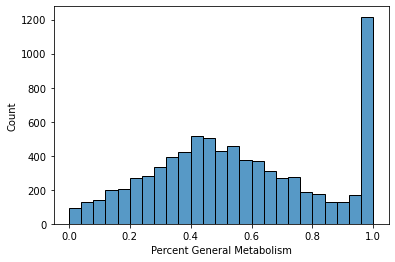

In [25]:
sns.histplot(data = percent_gm_pd, x ='Percent General Metabolism' )

In [26]:
high_gm_groups

GO_term
GO:0000030    1.0
GO:0000038    1.0
GO:0000096    1.0
GO:0000097    1.0
GO:0000098    1.0
             ... 
GO:1990380    1.0
GO:1990404    1.0
GO:1990756    1.0
GO:2000303    1.0
GO:2001034    1.0
Length: 1106, dtype: float64

In [27]:
filtered_groups_with_values

,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation
GO:0000002,0.881927,0.556401,mitochondrial genome maintenance,1,None
GO:0000003,0.852948,0.583122,reproduction,1,None
GO:0000018,0.901266,0.654468,regulation of DNA recombination,1,None
GO:0000027,0.940415,0.820107,ribosomal large subunit assembly,1,None
GO:0000028,0.937381,0.809442,ribosomal small subunit assembly,1,None
...,...,...,...,...,...
GO:0045086,0.897979,0.920487,NaN,1,None
GO:0045078,0.878603,0.788247,NaN,1,None
GO:0018065,0.885036,0.734161,NaN,1,None
GO:0051196,0.875306,0.638112,NaN,1,None


In [28]:
annotated_groups_human = filtered_groups_with_values

In [29]:
for group in annotated_groups_human.index:
    if annotated_groups_human.loc[group]['Annotation'] == 'None':
        if group in high_gm_groups.index:
            annotated_groups_human.at[group,'Annotation'] = 'Primary Metabolism'

In [30]:
annotated_groups_human

,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation
GO:0000002,0.881927,0.556401,mitochondrial genome maintenance,1,None
GO:0000003,0.852948,0.583122,reproduction,1,None
GO:0000018,0.901266,0.654468,regulation of DNA recombination,1,None
GO:0000027,0.940415,0.820107,ribosomal large subunit assembly,1,None
GO:0000028,0.937381,0.809442,ribosomal small subunit assembly,1,None
...,...,...,...,...,...
GO:0045086,0.897979,0.920487,NaN,1,None
GO:0045078,0.878603,0.788247,NaN,1,None
GO:0018065,0.885036,0.734161,NaN,1,Primary Metabolism
GO:0051196,0.875306,0.638112,NaN,1,None


In [31]:
only_annotated_groups = annotated_groups_human.loc[annotated_groups_human['Annotation'] != 'None']

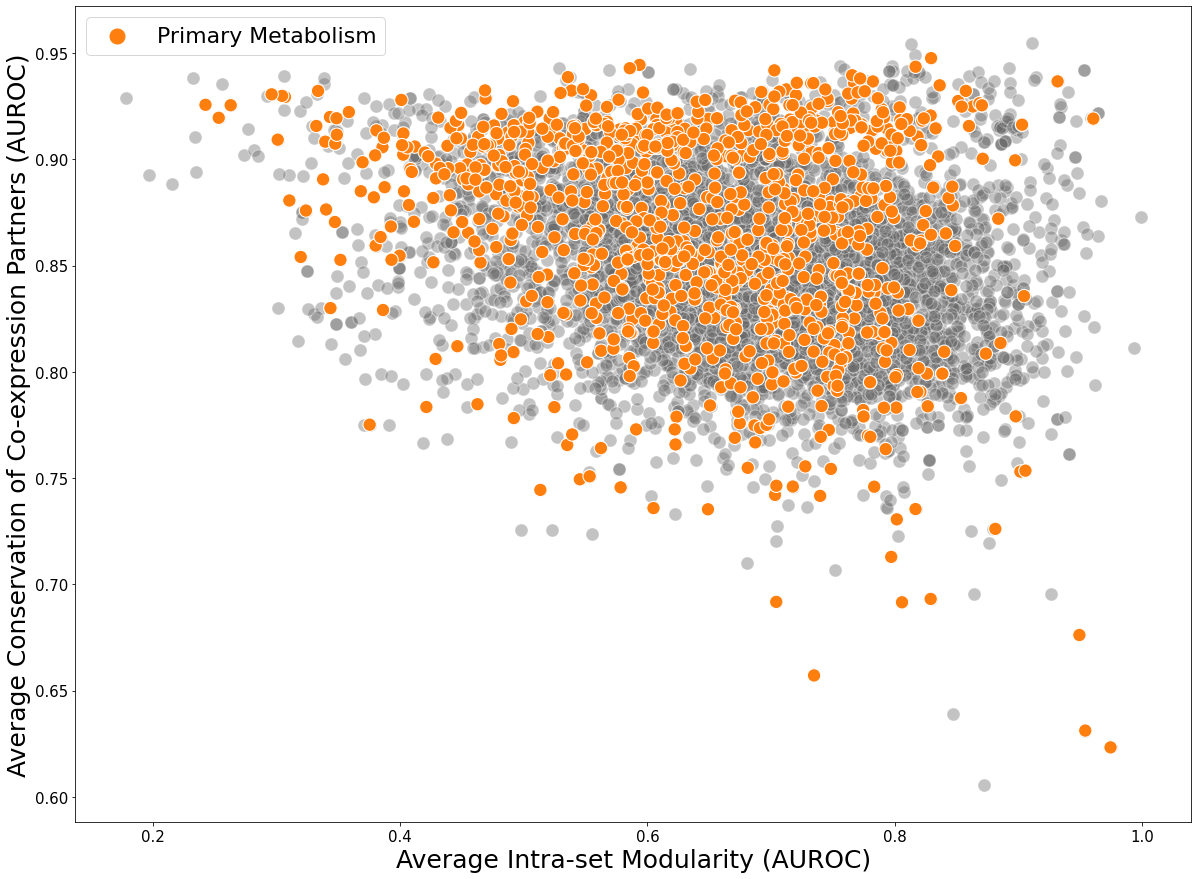

In [32]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = filtered_groups_with_values,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = only_annotated_groups, x = 'Avg EGAD',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Primary Metabolism'], palette = ['tab:orange'])

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

[Text(0, 0, 'Background'), Text(1, 0, 'Primary Metabolism')]

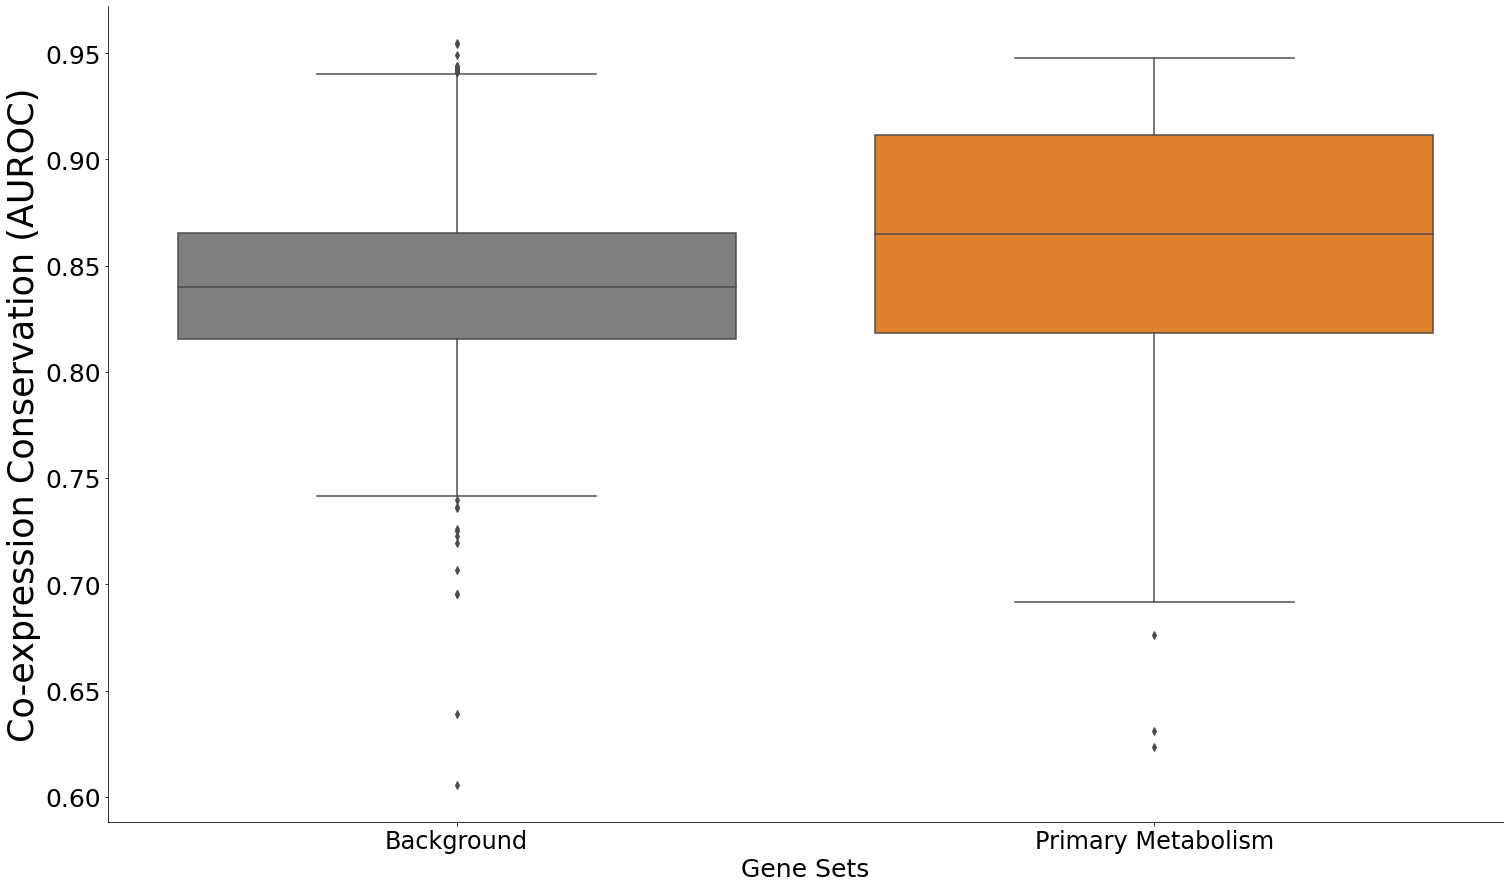

In [33]:
fig, ax = plt.subplots(figsize = (25,15))
sns.boxplot(data = annotated_groups_human.loc[annotated_groups_human['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['None','Primary Metabolism'], palette = ['tab:gray','tab:orange'])
plt.ylabel("Co-expression Conservation (AUROC)", fontsize = 35)
plt.xlabel("Gene Sets", fontsize = 25)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 25)
ax.set_xticklabels(labels = ['Background','Primary Metabolism'])

In [34]:
plant_annotated_group_list = pd.read_csv('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/gm_version_all_annotated_groups.csv',encoding = 'cp1252',index_col= 0)
plant_annotated_group_list = plant_annotated_group_list.drop(columns=['Notes'])
plant_annotated_group_list

,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation
GO:0000003,0.740324,0.634227,reproduction,10,None
GO:0000018,0.766573,0.798689,regulation of DNA recombination,8,None
GO:0000027,0.923946,0.869159,ribosomal large subunit assembly,9,Ribosomal
GO:0000028,0.951180,0.875073,ribosomal small subunit assembly,9,Ribosomal
GO:0000030,0.714718,0.642678,mannosyltransferase activity,8,None
...,...,...,...,...,...
GO:2001020,0.821085,0.761272,regulation of response to DNA damage stimulus,9,None
GO:2001070,0.720227,0.869219,starch binding,7,None
GO:2001141,0.722697,0.673483,regulation of RNA biosynthetic process,6,None
GO:2001251,0.778751,0.805120,negative regulation of chromosome organization,9,None


In [35]:
plant_annotated_group_list['Annotation'].loc[plant_annotated_group_list['Annotation'] == 'None'] = 'Plant None'
plant_annotated_group_list['Annotation'].loc[plant_annotated_group_list['Annotation'] == 'Primary Metabolism'] = 'Plant Primary Metabolism'

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [36]:
plant_annotated_group_list['Annotation'].value_counts()

Plant None                  2796
Ribosomal                     55
Plant Primary Metabolism      51
Hormonal                      42
Secondary Metabolism          40
Photosynthesis                27
Name: Annotation, dtype: int64

In [37]:
plant_annotated_group_list['Clade'] = 'Angiosperms'
plant_annotated_group_list

,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation,Clade
GO:0000003,0.740324,0.634227,reproduction,10,Plant None,Angiosperms
GO:0000018,0.766573,0.798689,regulation of DNA recombination,8,Plant None,Angiosperms
GO:0000027,0.923946,0.869159,ribosomal large subunit assembly,9,Ribosomal,Angiosperms
GO:0000028,0.951180,0.875073,ribosomal small subunit assembly,9,Ribosomal,Angiosperms
GO:0000030,0.714718,0.642678,mannosyltransferase activity,8,Plant None,Angiosperms
...,...,...,...,...,...,...
GO:2001020,0.821085,0.761272,regulation of response to DNA damage stimulus,9,Plant None,Angiosperms
GO:2001070,0.720227,0.869219,starch binding,7,Plant None,Angiosperms
GO:2001141,0.722697,0.673483,regulation of RNA biosynthetic process,6,Plant None,Angiosperms
GO:2001251,0.778751,0.805120,negative regulation of chromosome organization,9,Plant None,Angiosperms


In [38]:
annotated_groups_human['Annotation'].loc[annotated_groups_human['Annotation'] == 'None'] = 'Mammal None'
annotated_groups_human['Annotation'].loc[annotated_groups_human['Annotation'] == 'Primary Metabolism'] = 'Mammal Primary Metabolism'
annotated_groups_human['Clade'] = 'Mammals'
annotated_groups_human

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_2821848/4277757781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_groups_human['Clade'] = 'Mammals'


,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation,Clade
GO:0000002,0.881927,0.556401,mitochondrial genome maintenance,1,Mammal None,Mammals
GO:0000003,0.852948,0.583122,reproduction,1,Mammal None,Mammals
GO:0000018,0.901266,0.654468,regulation of DNA recombination,1,Mammal None,Mammals
GO:0000027,0.940415,0.820107,ribosomal large subunit assembly,1,Mammal None,Mammals
GO:0000028,0.937381,0.809442,ribosomal small subunit assembly,1,Mammal None,Mammals
...,...,...,...,...,...,...
GO:0045086,0.897979,0.920487,NaN,1,Mammal None,Mammals
GO:0045078,0.878603,0.788247,NaN,1,Mammal None,Mammals
GO:0018065,0.885036,0.734161,NaN,1,Mammal Primary Metabolism,Mammals
GO:0051196,0.875306,0.638112,NaN,1,Mammal None,Mammals


In [39]:
combined_species_groups = annotated_groups_human.append(plant_annotated_group_list)

[Text(0, 0, 'Mammal Background'),
 Text(1, 0, 'Plant Background'),
 Text(2, 0, 'Mammal Primary Metabolism'),
 Text(3, 0, 'Plant Primary Metabolism')]

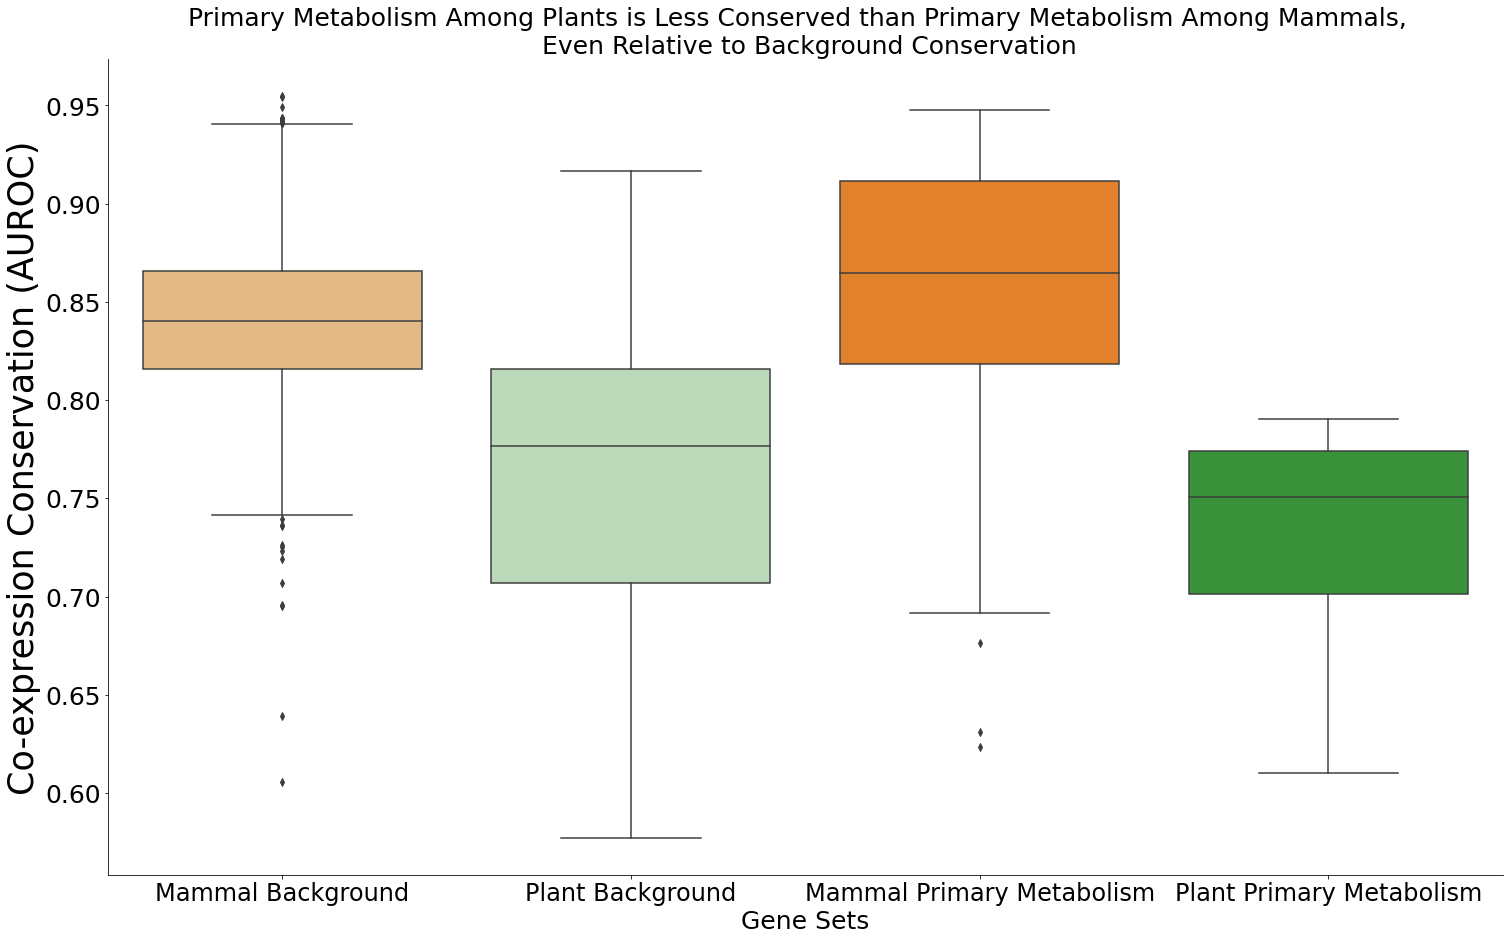

In [40]:
fig, ax = plt.subplots(figsize = (25,15))
fig.patch.set_facecolor('white')
sns.boxplot(data = combined_species_groups.loc[combined_species_groups['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['Mammal None','Plant None','Mammal Primary Metabolism','Plant Primary Metabolism'], palette = ['#f2bc77','#b7deb4','tab:orange','tab:green'])
plt.ylabel("Co-expression Conservation (AUROC)", fontsize = 35)
plt.xlabel("Gene Sets", fontsize = 25)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Primary Metabolism Among Plants is Less Conserved than Primary Metabolism Among Mammals,  \n Even Relative to Background Conservation", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 25)
ax.set_xticklabels(labels = ['Mammal Background','Plant Background','Mammal Primary Metabolism', 'Plant Primary Metabolism'])

[Text(0, 0, 'Mammal Background'),
 Text(1, 0, 'Plant Background'),
 Text(2, 0, 'Mammal Primary Metabolism'),
 Text(3, 0, 'Plant Primary Metabolism')]

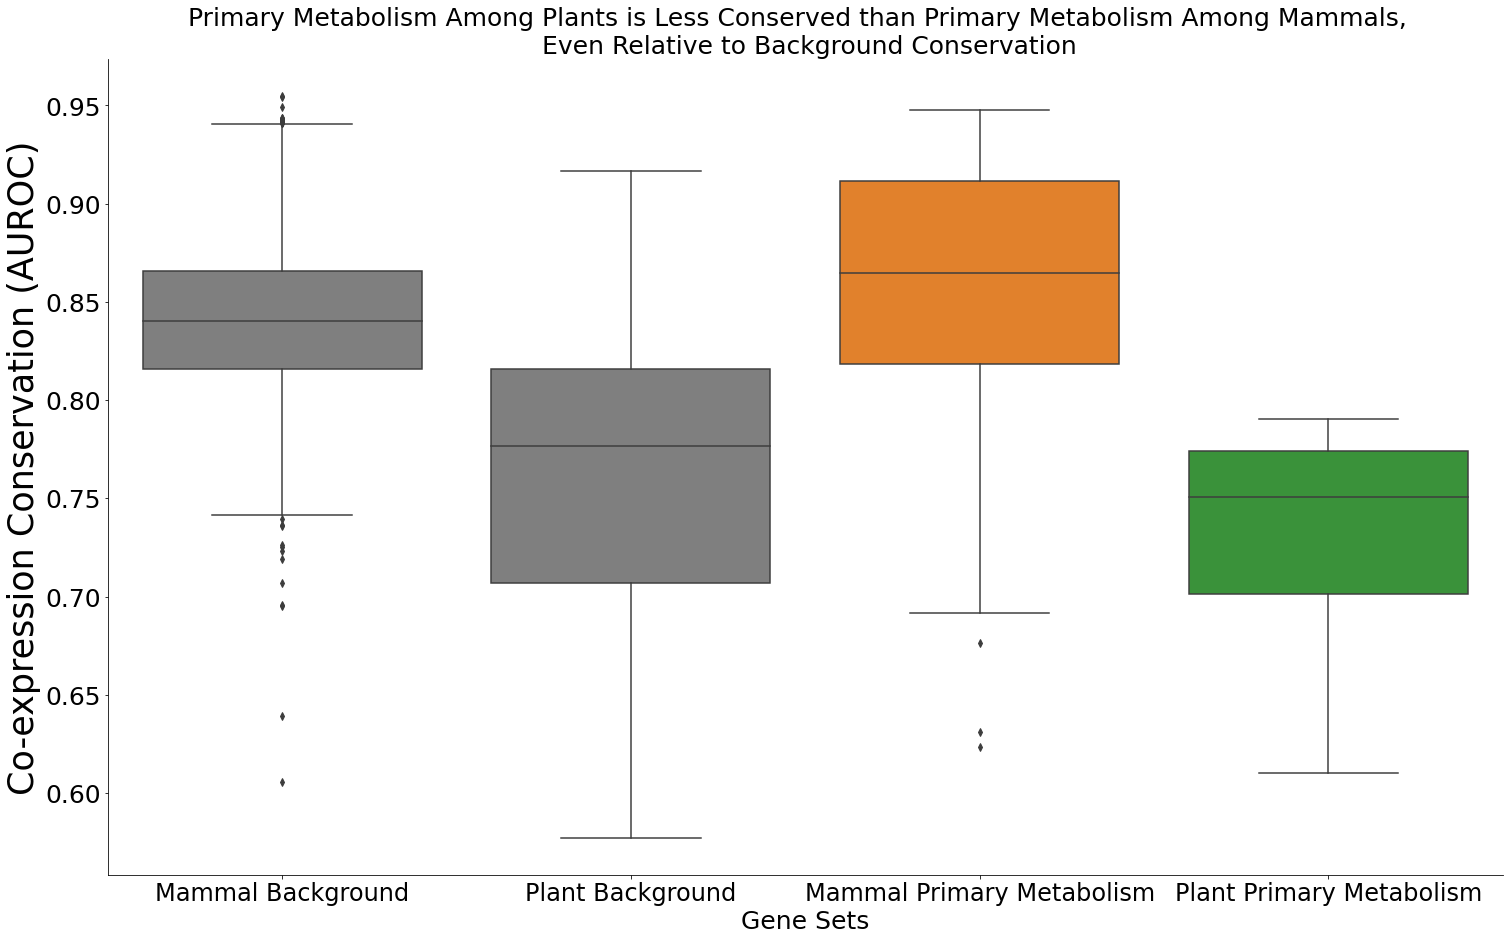

In [41]:
fig, ax = plt.subplots(figsize = (25,15))
fig.patch.set_facecolor('white')
sns.boxplot(data = combined_species_groups.loc[combined_species_groups['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['Mammal None','Plant None','Mammal Primary Metabolism','Plant Primary Metabolism'], palette = ['tab:gray','tab:gray','tab:orange','tab:green'])
plt.ylabel("Co-expression Conservation (AUROC)", fontsize = 35)
plt.xlabel("Gene Sets", fontsize = 25)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Primary Metabolism Among Plants is Less Conserved than Primary Metabolism Among Mammals,  \n Even Relative to Background Conservation", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 25)
ax.set_xticklabels(labels = ['Mammal Background','Plant Background','Mammal Primary Metabolism', 'Plant Primary Metabolism'])

In [42]:
combined_species_groups['Annotation'].value_counts()

Mammal None                  6873
Plant None                   2796
Mammal Primary Metabolism    1106
Ribosomal                      55
Plant Primary Metabolism       51
Hormonal                       42
Secondary Metabolism           40
Photosynthesis                 27
Name: Annotation, dtype: int64

[Text(0, 0, 'Mammal Background'),
 Text(1, 0, 'Plant Background'),
 Text(2, 0, 'Mammal Primary Metabolism'),
 Text(3, 0, 'Plant Primary Metabolism'),
 Text(4, 0, 'Plant Secondary Metabolism')]

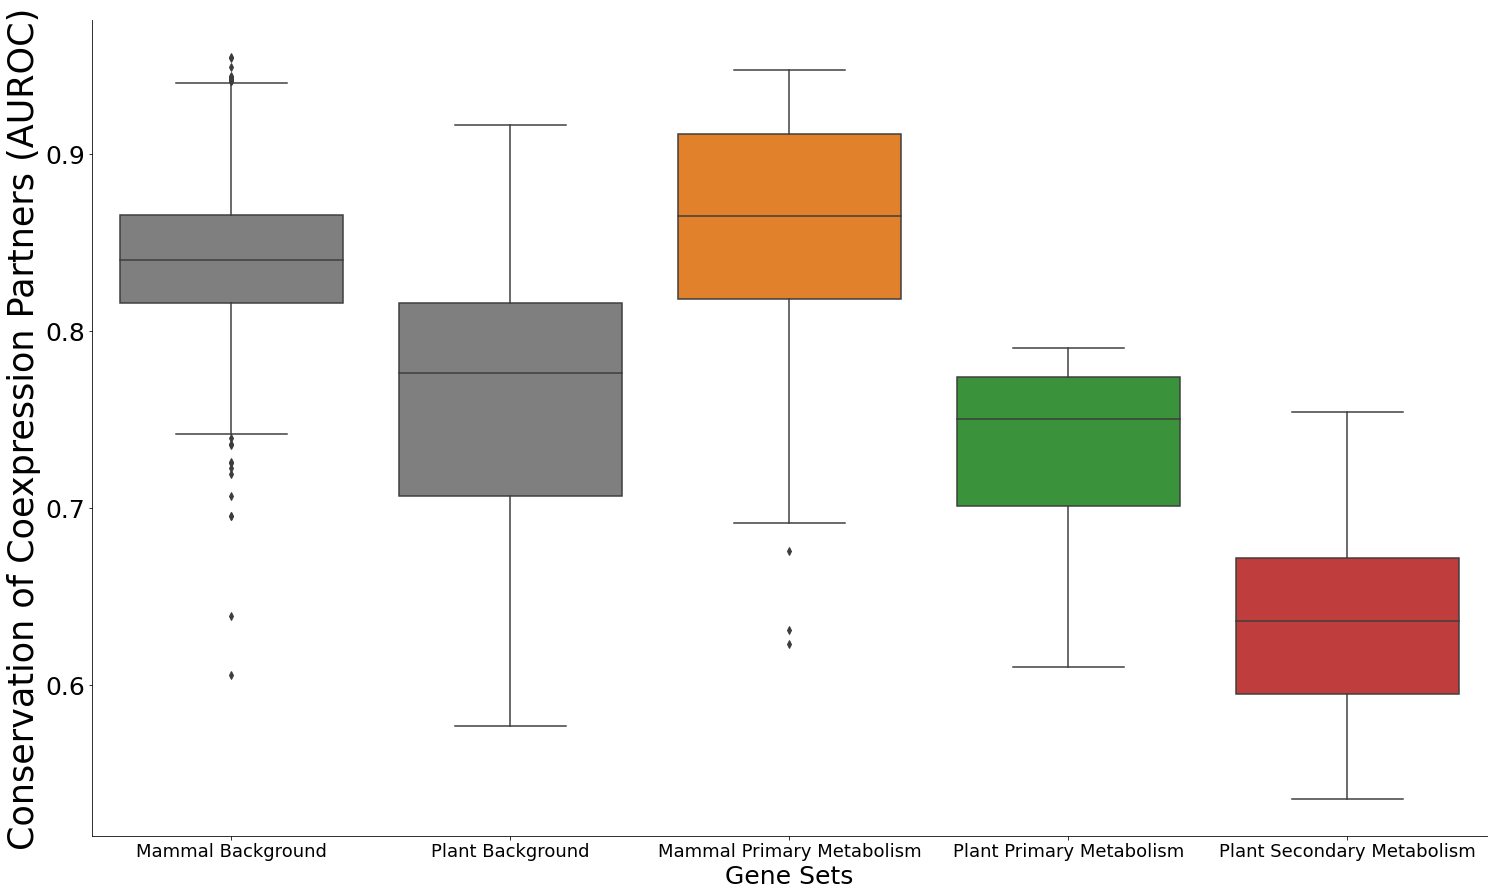

In [43]:
fig, ax = plt.subplots(figsize = (25,15))
fig.patch.set_facecolor('white')
sns.boxplot(data = combined_species_groups.loc[combined_species_groups['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['Mammal None','Plant None','Mammal Primary Metabolism','Plant Primary Metabolism', 'Secondary Metabolism'], palette = ['tab:gray','tab:gray','tab:orange','tab:green', 'tab:red'])
plt.ylabel("Conservation of Coexpression Partners (AUROC)", fontsize = 35)
plt.xlabel("Gene Sets", fontsize = 25)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
#plt.title("Primary Metabolism Among Plants is Less Conserved than Primary Metabolism Among Mammals,  \n Even Relative to Background Conservation", fontsize = 25)
plt.xticks(fontsize = 18,)
plt.yticks(fontsize = 25)
ax.set_xticklabels(labels = ['Mammal Background','Plant Background','Mammal Primary Metabolism', 'Plant Primary Metabolism', 'Plant Secondary Metabolism'])

[Text(0, 0, 'Mammal Background'),
 Text(1, 0, 'Plant Background'),
 Text(2, 0, 'Mammal Primary Metabolism'),
 Text(3, 0, 'Plant Primary Metabolism'),
 Text(4, 0, 'Plant Secondary Metabolism')]

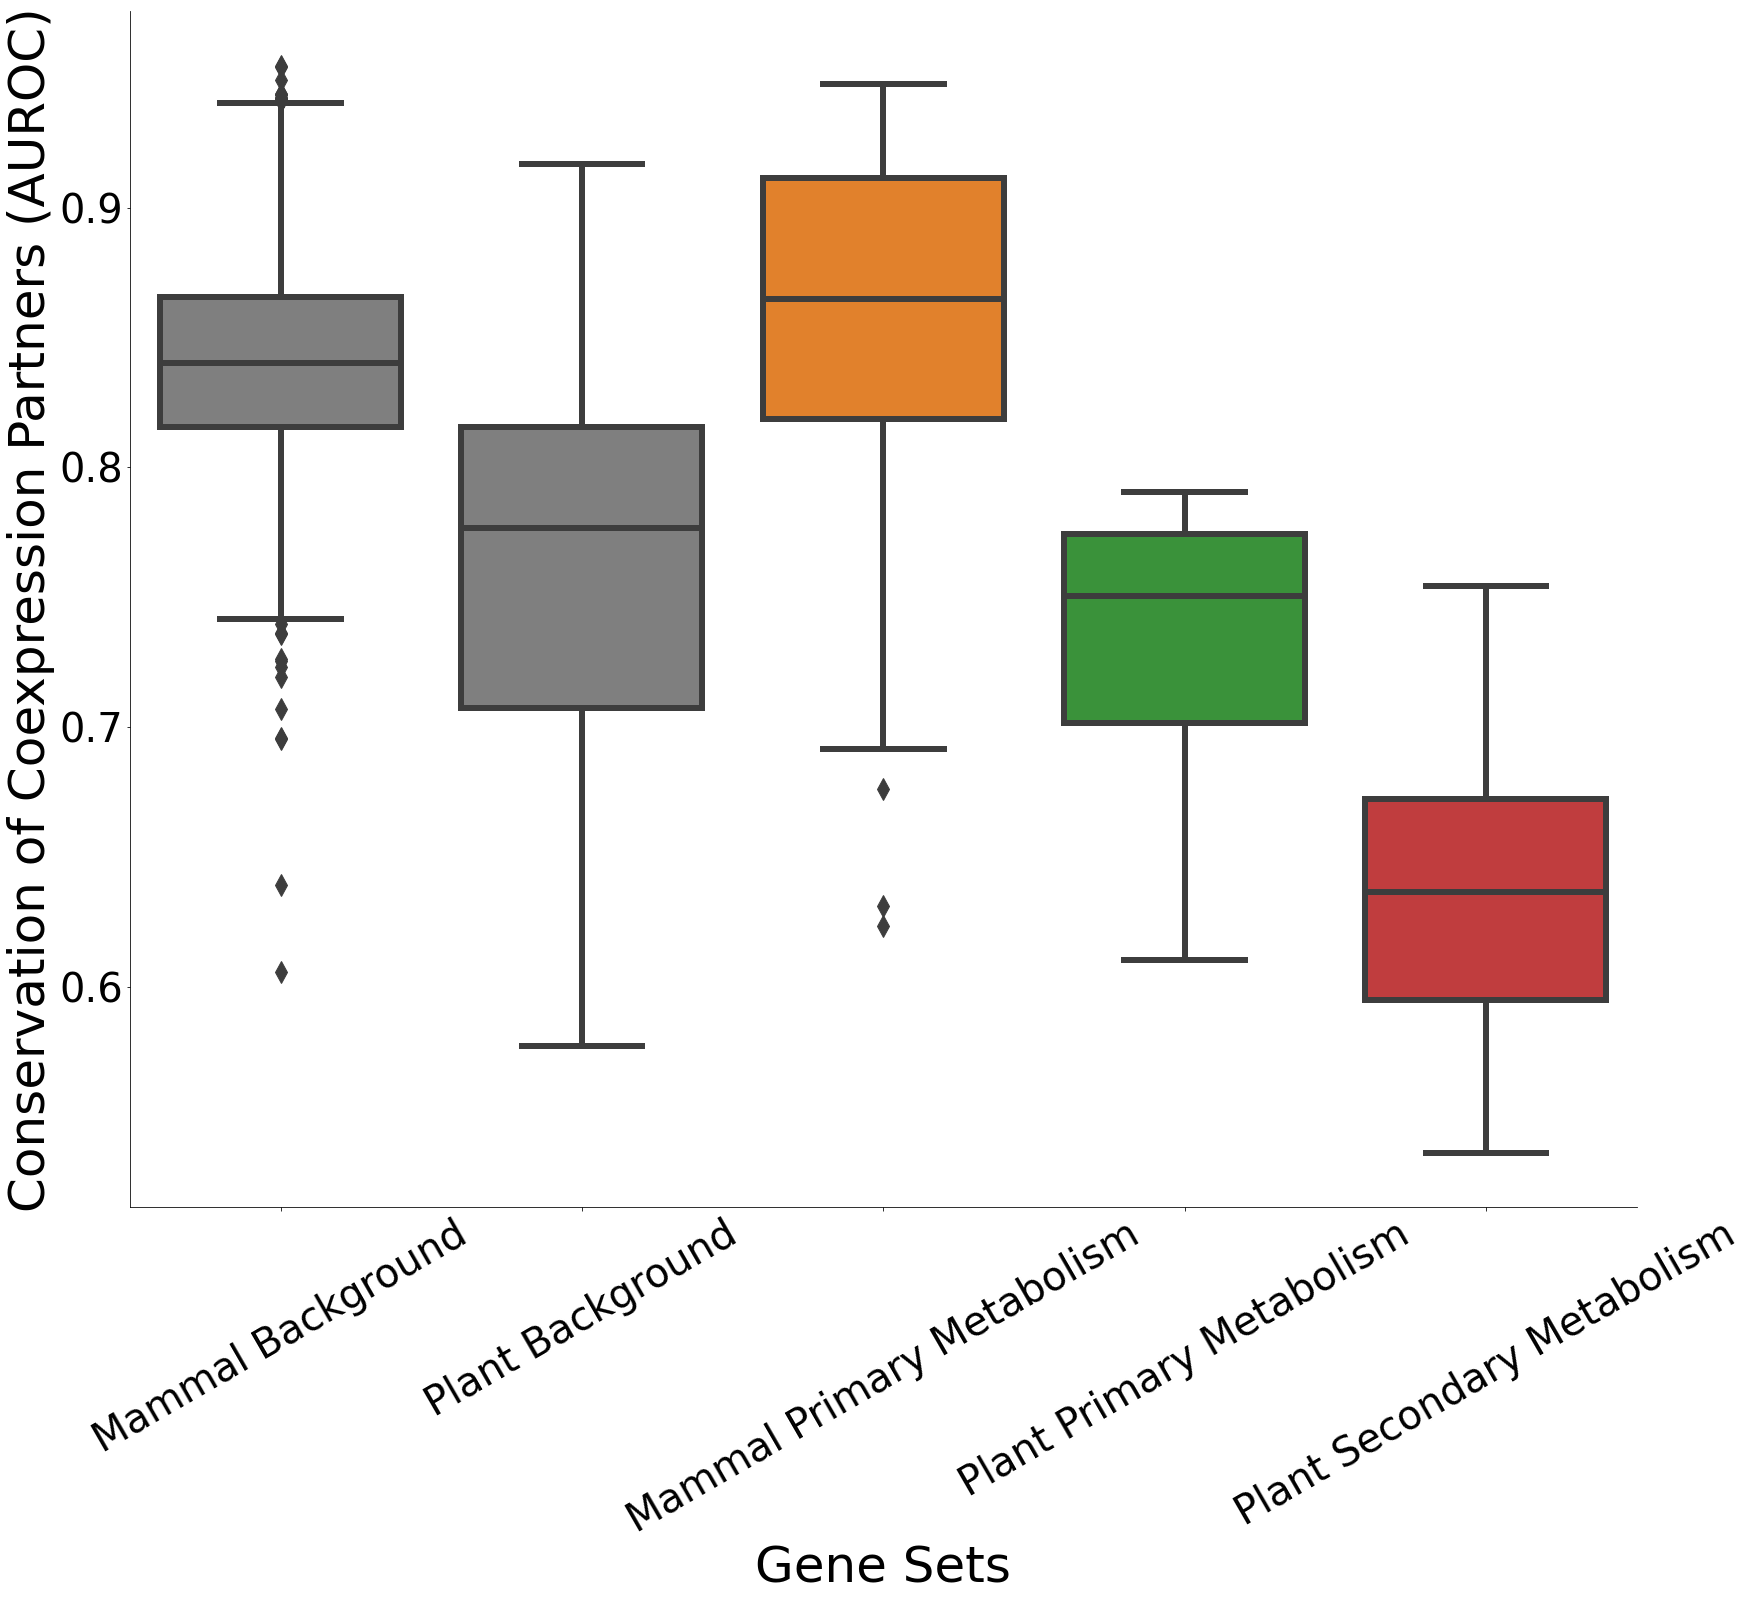

In [48]:
fig, ax = plt.subplots(figsize = (27,22))
fig.patch.set_facecolor('white')
sns.boxplot(data = combined_species_groups.loc[combined_species_groups['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['Mammal None','Plant None','Mammal Primary Metabolism','Plant Primary Metabolism', 'Secondary Metabolism'], palette = ['tab:gray','tab:gray','tab:orange','tab:green', 'tab:red'], linewidth = 6, fliersize = 15)
plt.ylabel("Conservation of Coexpression Partners (AUROC)", fontsize = 50)
plt.xlabel("Gene Sets", fontsize = 50)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
#plt.title("Primary Metabolism Among Plants is Less Conserved than Primary Metabolism Among Mammals,  \n Even Relative to Background Conservation", fontsize = 25)
plt.xticks(fontsize = 40, rotation = 30)
plt.yticks(fontsize = 40)
ax.set_xticklabels(labels = ['Mammal Background','Plant Background','Mammal Primary Metabolism', 'Plant Primary Metabolism', 'Plant Secondary Metabolism'])
#plt.savefig('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Metabolics_analysis/Figures/Poster_figure_metabolism.png',transparent=True,bbox_inches="tight")

In [45]:
nested_grouping_species_groups = combined_species_groups.copy()
nested_grouping_species_groups['Annotation'].loc[nested_grouping_species_groups['Annotation'] == 'Mammal None'] = "Background"
nested_grouping_species_groups['Annotation'].loc[nested_grouping_species_groups['Annotation'] == 'Plant None'] = "Background"
nested_grouping_species_groups['Annotation'].loc[nested_grouping_species_groups['Annotation'] == 'Mammal Primary Metabolism'] = "Primary Metabolism"
nested_grouping_species_groups['Annotation'].loc[nested_grouping_species_groups['Annotation'] == 'Plant Primary Metabolism'] = "Primary Metabolism"
nested_grouping_species_groups =nested_grouping_species_groups.loc[nested_grouping_species_groups['Annotation'].isin(['Background','Primary Metabolism'])]
nested_grouping_species_groups


/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation,Clade
GO:0000002,0.881927,0.556401,mitochondrial genome maintenance,1,Background,Mammals
GO:0000003,0.852948,0.583122,reproduction,1,Background,Mammals
GO:0000018,0.901266,0.654468,regulation of DNA recombination,1,Background,Mammals
GO:0000027,0.940415,0.820107,ribosomal large subunit assembly,1,Background,Mammals
GO:0000028,0.937381,0.809442,ribosomal small subunit assembly,1,Background,Mammals
...,...,...,...,...,...,...
GO:2001020,0.821085,0.761272,regulation of response to DNA damage stimulus,9,Background,Angiosperms
GO:2001070,0.720227,0.869219,starch binding,7,Background,Angiosperms
GO:2001141,0.722697,0.673483,regulation of RNA biosynthetic process,6,Background,Angiosperms
GO:2001251,0.778751,0.805120,negative regulation of chromosome organization,9,Background,Angiosperms


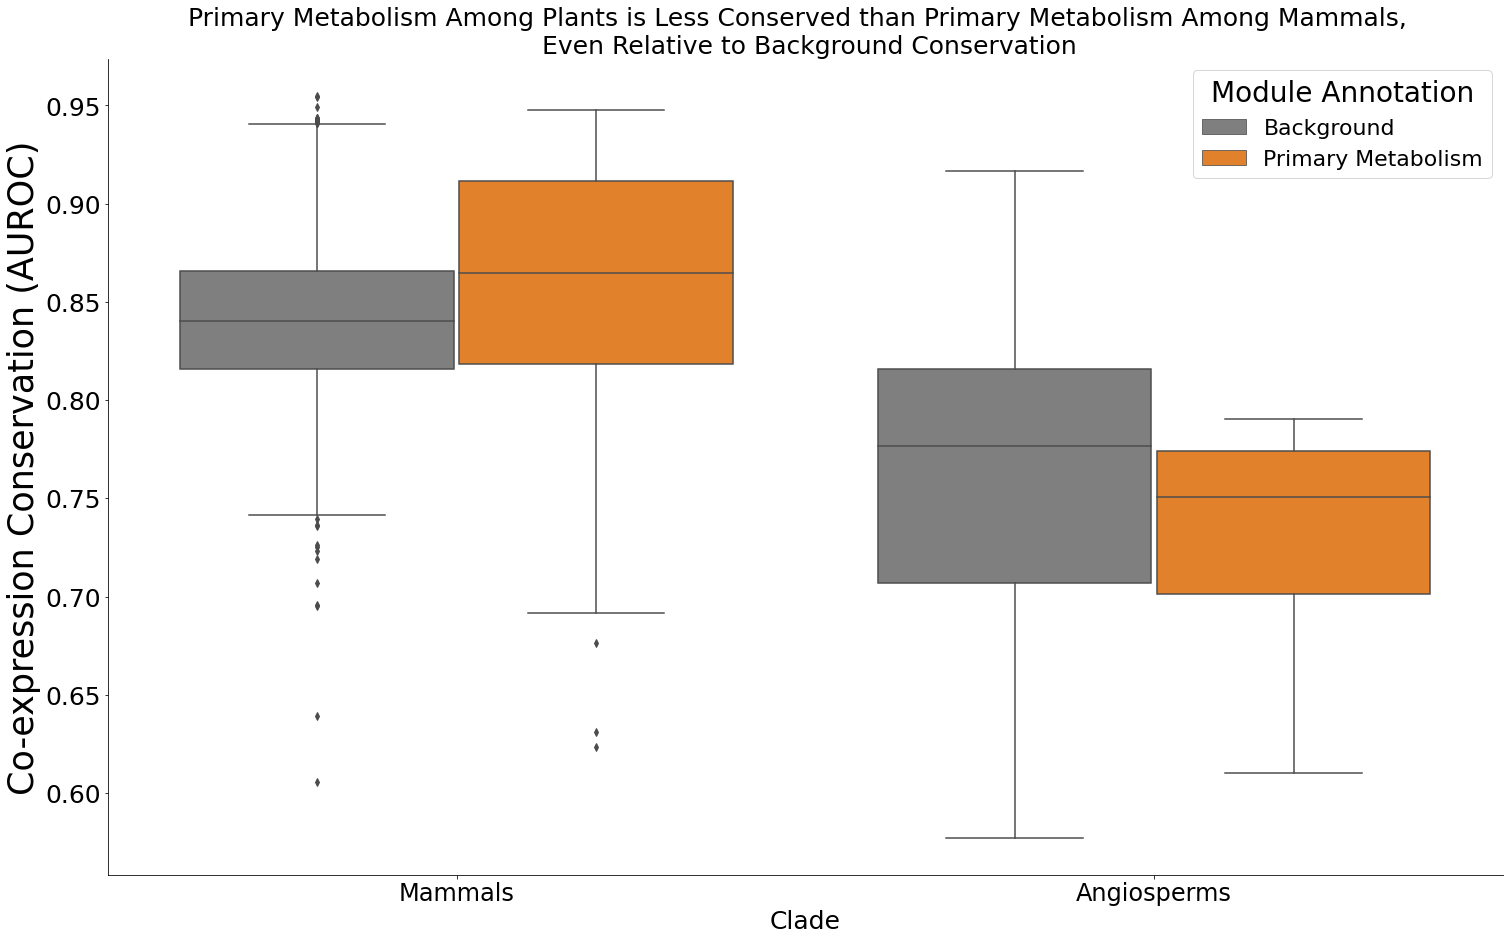

In [46]:
fig, ax = plt.subplots(figsize = (25,15))
fig.patch.set_facecolor('white')
sns.boxplot(data = nested_grouping_species_groups.loc[nested_grouping_species_groups['Avg EGAD']>.75], x = 'Clade',y = 'Avg FC',hue = 'Annotation',palette = ['tab:gray','tab:orange',])
plt.ylabel("Co-expression Conservation (AUROC)", fontsize = 35)
plt.xlabel("Clade", fontsize = 25)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.title("Primary Metabolism Among Plants is Less Conserved than Primary Metabolism Among Mammals,  \n Even Relative to Background Conservation", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 25)
plt.legend(fontsize= 22,markerscale = 2.5,title = 'Module Annotation',title_fontsize = 28)


[Text(0, 0, 'Mammal Background'),
 Text(1, 0, 'Plant Background'),
 Text(2, 0, 'Mammal Primary Metabolism'),
 Text(3, 0, 'Plant Primary Metabolism')]

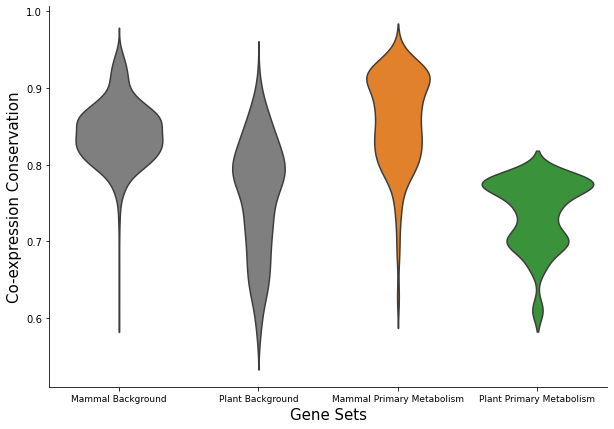

In [47]:
fig, ax = plt.subplots(figsize = (10,7))
fig.patch.set_facecolor('white')
sns.violinplot(data = combined_species_groups.loc[combined_species_groups['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['Mammal None','Plant None','Mammal Primary Metabolism','Plant Primary Metabolism'], palette = ['tab:gray','tab:gray','tab:orange','tab:green'], bw = .3, inner = None)
plt.ylabel("Co-expression Conservation", fontsize = 15)
plt.xlabel("Gene Sets", fontsize = 15)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
#plt.title("Primary Metabolism Among Plants is Less Conserved than Primary Metabolism Among Mammals,  \n Even Relative to Background Conservation", fontsize = 25)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 10)
ax.set_xticklabels(labels = ['Mammal Background','Plant Background','Mammal Primary Metabolism', 'Plant Primary Metabolism'])